In [1]:
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
from simple_veloce_reduction import veloce_config, veloce_logs, veloce_extraction, veloce_reduction_tools

Set up info about run and target(s)

In [3]:
data_dirs = {'red': 'ccd_3', 'green': 'ccd_2', 'blue': 'ccd_1'}

In [4]:
config, veloce_paths = veloce_config.load_config('config.yaml')

In [5]:
config = {
    'reduce': "run",
    'run': "CSV_Run",
    'date': None, # date of the observation (YYMMDD), if reduce is 'night' or 'file'
    'filename': None, # name of the file to reduce, if reduce is 'file'
    'science_targets': "targets.dat", # file containg list of science targets
    'calib_type': "Static", # Wavelength calibration to use SimLC, SimThXe, Interpolate or Static
    # secondary information for the reduction
    'arm': "green", # Which arm to reduce 'all', 'red', 'green' or 'blue'
    'amplifier_mode': 4, # 2 or 4
    'sim_calib': True, # Flag indicating if simultaneous ca True or False
    'plot_diagnostic': True, # True or False
    'scattered_light': False, # try to remove scattered light True or False
    'flat_field': False, # True or False

    # part responsible for the paths
    'raw_parent_dir': os.path.join(os.getcwd(), "Data", "Raw"), # path to the directory with raw data (one in which the run directory is, i.e. input directory)
    'extracted_parent_dir': os.path.join(os.getcwd(), "Data", "Extracted"), # path to the directory where extracted data will be stored (i.e. output directory)
    # below are paths where code will stor intermediet files and diagnostics
    # by default they are set as subdirectories of output directory with extracted data
    'blaze_dir': "Default",
    'master_dir': "Default",
    'wavelength_calibration_dir': "Default",
    'obs_list_dir': "Default",
    'plot_dir': "Default",
    'log_dir': "Default",
    # below are paths where code will look for internal files
    # leave as default unless you know what you are doing
    # veloce_reduction_dir: Default
    'trace_dir': "Default", # path to the directory with traces to be extracted
    'wave_dir': "Default", # path to the directory static wavelength solution
}

veloce_paths = veloce_config.VelocePaths.from_config(config)
science_targets = veloce_config.load_target_list(config['science_targets'])

In [6]:
# run = "CSV_Run"
# veloce_paths = veloce_config.VelocePaths(run)
# veloce_paths.__post_init__()

# science_targets = ['HD20203-USQ01']

# arm = 'green'

# # Days and dates are redundant, should make one automatically generated from the other
# dates = ['230826'] # can be drawn from dirs present in the run directory
# days = ['26aug'] 

Step 1 - read data filenames from logs

In [7]:
obs_list = veloce_logs.load_run_logs(config['run'], science_targets, config['arm'])

In [8]:
# for day, date in zip(days, dates):
#     log_path = os.path.join(veloce_paths.raw_parent_dir, run, date)
#     log_name = [name for name in os.listdir(log_path) if name.split('.')[-1] == 'log'][0]
#     log_path = os.path.join(log_path, log_name)
#     temp_obs_list = veloce_logs.load_log_info(log_path, science_targets, arm, day, calib_type)
#     for key in temp_obs_list:
#         obs_list[key][date] = temp_obs_list[key]

Step 2 - save targets list

In [13]:
obs_list = veloce_logs.get_obs_list(obs_list['science'])
#  obs_list_name = veloce_logs.save_science_target_list(obs_list['science'], run=config['run'])
# can be done also by target
# and with custom filename for resulting file

Step 3 - Extract science data


In [14]:
# output_path = veloce_paths.extracted_parent_dir
veloce_extraction.extract_run_no_blaze(
            obs_list, config['run'],
            config['arm'], config['amplifier_mode'],
            sim_calib=config['sim_calib'], remove_background=config['scattered_light'],
            veloce_paths=veloce_paths)

HD20203-USQ01 26aug20146.fits
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01
HD20203-USQ01 26aug20147.fits
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01
HD20203-USQ01 26aug20148.fits
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01
HD20203-USQ01 26aug20149.fits
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01
HD20203-USQ01 26aug20150.fits
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01
HD20203-USQ01 26aug20151.fits
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01
HD20203-USQ01 26aug20152.fits
Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01
HD20203-USQ01 26aug20153.fits
Gain for quadrant 1: 1.01
Gain f

In [17]:
filename = os.listdir(veloce_paths.extracted_dir)[0]
wave, flux, hdr = veloce_reduction_tools.load_extracted_spectrum_fits(os.path.join(veloce_paths.extracted_dir, filename))

Text(0, 0.5, 'Flux [ADU]')

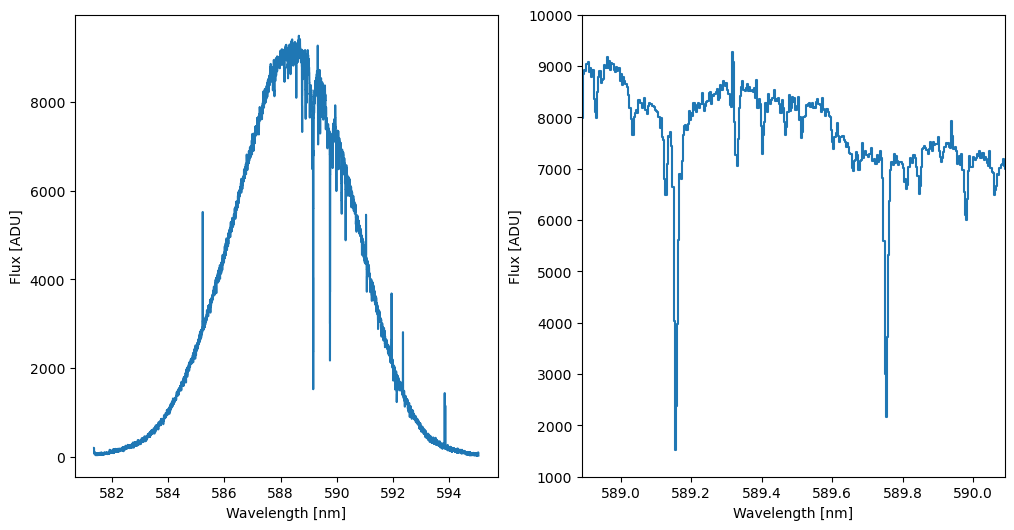

In [18]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].step(wave[1], flux[1], where='mid')
ax[0].set_xlabel('Wavelength [nm]')
ax[0].set_ylabel('Flux [ADU]')
ax[1].step(wave[1], flux[1], where='mid')
plt.xlim(588.89, 590.09)
plt.ylim(1000, 10000)
ax[1].set_xlabel('Wavelength [nm]')
ax[1].set_ylabel('Flux [ADU]')

(optional) Step 4 - Make master flats (based on file list)

In [6]:
master_type = f'flat_{arm}'

for date in obs_list[master_type].keys():
    if obs_list[master_type][date] != []:
        master_flat, hdr = veloce_reduction_tools.get_master(obs_list,
                            master_type, veloce_paths.raw_parent_dir, run, date, arm)
        master_flat_filename =  f'master_{master_type}_{date}.fits'
        veloce_reduction_tools.save_image_fits(master_flat_filename, veloce_paths.master_dir, master_flat, hdr)

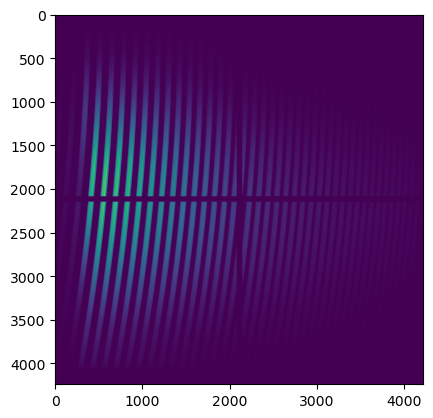

In [7]:
plt.imshow(master_flat)

In [8]:
from scipy.ndimage import median_filter

In [9]:
def make_normalised_master_flat(master_filename, master_path, amplifier_mode):
    with fits.open(os.path.join(master_path, master_filename)) as hdul:
        flat_image = hdul[0].data
        hdr = hdul[0].header
    # print(flat_image.shape)
    flat_subtracted_bias = veloce_reduction_tools.remove_overscan_bias(flat_image, hdr, overscan_range=32, amplifier_mode=4)
    # print(flat_subtracted_bias.shape)
    smoothed_flat = median_filter(flat_subtracted_bias, (21,21))
    # print(smoothed_flat.shape)
    if np.any(smoothed_flat <= 0):
        print(np.min(smoothed_flat))
        smoothed_flat+=1
        
    normalised_flat = flat_subtracted_bias / (smoothed_flat+1)
    hdr['NAXIS1'] = normalised_flat.shape[1]
    hdr['NAXIS2'] = normalised_flat.shape[0]
    normalised_flat_name = master_filename.split('.')[0]+'_norm.fits'
    veloce_reduction_tools.save_image_fits(normalised_flat_name, master_path, normalised_flat, hdr)
    
    return normalised_flat, hdr, normalised_flat_name

In [10]:
norm_master_flat, header, norm_flat_filename = make_normalised_master_flat(master_flat_filename, veloce_paths.master_dir, 4)

Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01


In [32]:
%matplotlib widget

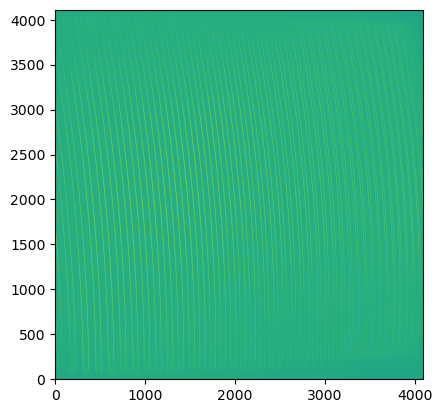

In [11]:
plt.imshow(norm_master_flat, origin='lower', cmap='viridis', norm='log') 

In [12]:
np.min(norm_master_flat), np.max(norm_master_flat), np.median(norm_master_flat), np.mean(norm_master_flat), np.std(norm_master_flat)

(0.0,
 16.41318124207858,
 0.9880028228652081,
 1.0960487900143396,
 0.7124315225131848)

In [13]:
filename = os.path.join(veloce_paths.trace_dir, f'veloce_{arm}_4amp_no_sim_calib_trace.pkl')
traces = veloce_reduction_tools.Traces.load_traces(filename)

In [14]:
master_flat_subtracted = veloce_reduction_tools.remove_overscan_bias(master_flat, hdr, overscan_range=32, amplifier_mode=4)

Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01


In [35]:
extracted_master, extracted_master_img = veloce_reduction_tools.extract_orders_with_trace(master_flat, traces)

extracted_norm, extracted_norm_img = veloce_reduction_tools.extract_orders_with_trace(norm_master_flat, traces)

In [ ]:
veloce_reduction_tools.plot_order_cross_section

In [11]:
# veloce_extraction.extract_blaze(master_flat_filename, arm=f"{arm}")

In [38]:
plt.close('all')

In [39]:
%matplotlib inline

In [31]:
filter_size = 5

In [32]:
blured_5 = median_filter(master_flat_subtracted, filter_size)

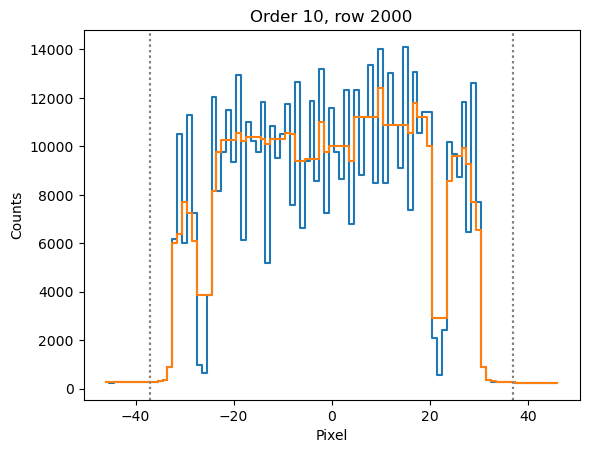

In [34]:
veloce_reduction_tools.plot_order_cross_section(master_flat_subtracted, traces, 10, plot_type=2000, margin=[10,10])
veloce_reduction_tools.plot_order_cross_section(blured_5, traces, 10, plot_type=2000, margin=[10,10])
# veloce_reduction_tools.plot_order_cross_section(norm_master_flat, traces, 10, plot_type='median', margin=[10,10])
plt.savefig(f'flatfield_order_cross_section_filtersize_{filter_size}.png')

/tmp/ipykernel_326135/3236145599.py:1: RuntimeWarning: divide by zero encountered in divide
  veloce_reduction_tools.plot_order_cross_section(master_flat_subtracted/blured_5, traces, 10, plot_type=2000, margin=[10,10])


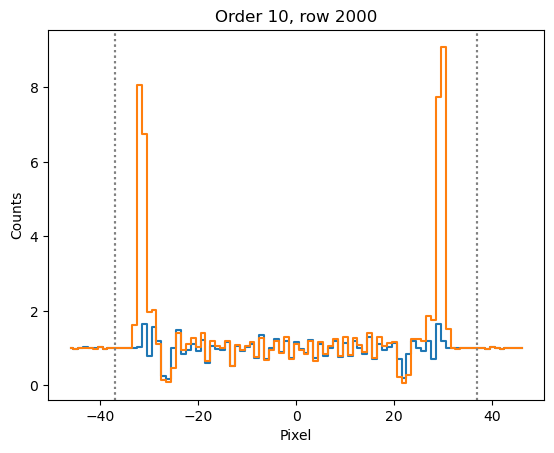

In [35]:
veloce_reduction_tools.plot_order_cross_section(master_flat_subtracted/blured_5, traces, 10, plot_type=2000, margin=[10,10])
veloce_reduction_tools.plot_order_cross_section(master_flat_subtracted/blured_21, traces, 10, plot_type=2000, margin=[10,10])
plt.savefig(f'norm_flatfield_order_cross_section_filtersize_comparison.png')

In [21]:
norm_master_flat.shape, master_flat.shape

((4224, 4208), (4240, 4224))